In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,3,12,16,480,91,799,800] #C2
# plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
#        '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
#        '127_20220705', '130_20220707', '152_20201224',"3_20220426", "12_20220502","16_20220419","480_20221205", '52_20220707', '76_20210108',
#        '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']
plates = ['1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413'
         ]
# plates += [
# "850_20230511",
# "840_20230404",
# "861_20230411"
# ]
plates += ["527_20230106","537_20230111"]
# plates += ["462_20221013"]
# plates += ["532_20220104"]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)

In [3]:
time_hypha_info['unique_hypha']=time_hypha_info["end"].astype(int).astype(str)+"_"+time_hypha_info["unique_id"].astype(str)
global_hypha_info['unique_hypha'] = global_hypha_info["index"].astype(int).astype(str)+"_"+global_hypha_info["unique_id"].astype(str)

In [4]:
min_num_occ = 3
max_speeds = time_hypha_info.groupby("unique_hypha").max()["speed"]
correct_tracks = max_speeds.loc[max_speeds <= 450]
select = time_hypha_info.loc[time_hypha_info["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["distance_final_pos"] >= 400]
select = select.loc[select["speed"].between(80, 400)]
select = select.loc[select["in_ROI"] == "True"]
num_occ = select.groupby("unique_hypha").count()["speed"]
correct_tracks = num_occ.loc[num_occ >= min_num_occ]
select = select.loc[select["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["width_tip_edge"].between(3,12)]
select_glob = global_hypha_info.loc[global_hypha_info['unique_hypha'].isin(select['unique_hypha'])]
select_glob = select_glob.loc[select_glob['mean_speed'].between(100,300)]
select_glob = select_glob.loc[select_glob['av_width_final'].between(1,20)]

In [5]:
bin_widths = np.arange(np.floor(select_glob['av_width_final'].min()), np.ceil(select_glob['av_width_final'].max()) + 1)
binned_speeds = [select_glob['mean_speed'][np.floor(select_glob['av_width_final']) == width] for width in bin_widths]

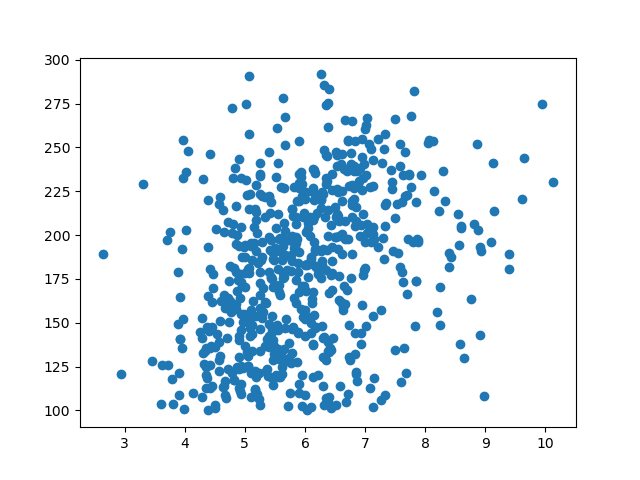

In [6]:
fig,ax = plt.subplots()
ax.scatter(select_glob['av_width_final'],select_glob['mean_speed'])

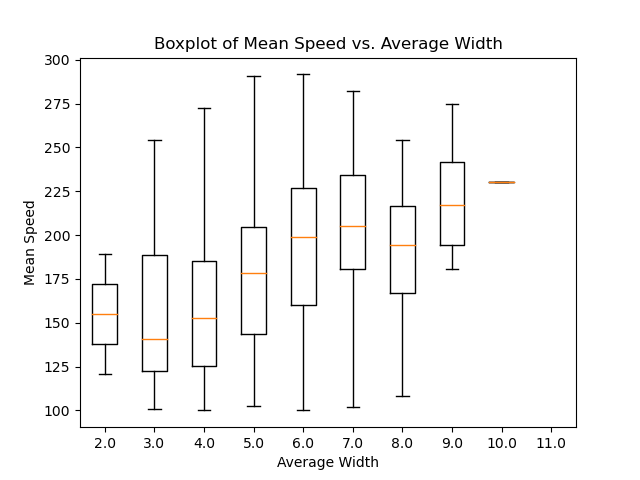

In [7]:
fig, ax = plt.subplots()
ax.boxplot(binned_speeds, labels=bin_widths)
ax.set_xlabel('Average Width')
ax.set_ylabel('Mean Speed')
ax.set_title('Boxplot of Mean Speed vs. Average Width')
plt.show()

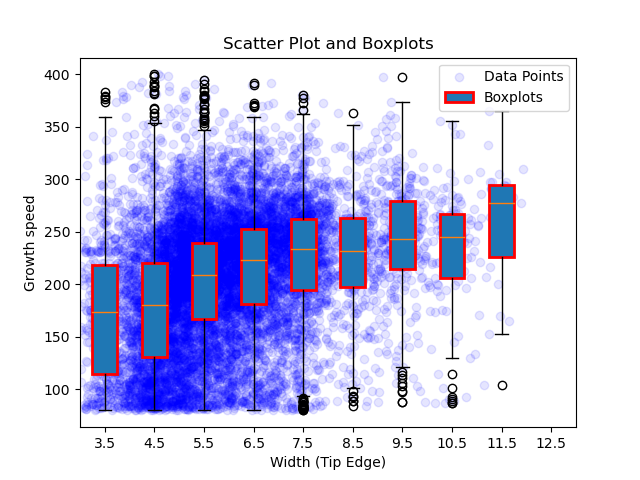

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace this with your actual data)
speed_data = select['speed']
width_data = select['width_tip_edge']

# Bin the data by integer values of 'width_tip_edge'
bin_widths = np.arange(np.floor(width_data.min()), np.ceil(width_data.max()) + 1)
binned_speeds = [speed_data[np.floor(width_data) == width] for width in bin_widths]
bin_widths += 0.5
# Create a scatter plot and overlay boxplots for each bin
fig, ax = plt.subplots()
scatter = ax.scatter(width_data, speed_data, c='blue', alpha=0.1, label='Data Points')
boxprops = dict(color='red', linewidth=2)
box = ax.boxplot(binned_speeds, positions=bin_widths, patch_artist=True, boxprops=boxprops)
ax.set_ylabel('Growth speed')
ax.set_xlabel('Width (Tip Edge)')
ax.set_title('Scatter Plot and Boxplots')
ax.legend([scatter, box['boxes'][0]], ['Data Points', 'Boxplots'])

plt.show()


In [19]:
min_num_occ = 15
max_speeds = time_hypha_info.groupby("unique_hypha").max()["speed"]
correct_tracks = max_speeds.loc[max_speeds <= 450]
select = time_hypha_info.loc[time_hypha_info["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["distance_final_pos"] >= 400]
select = select.loc[select["speed"].between(80, 400)]
select = select.loc[select["in_ROI"] == "True"]
num_occ = select.groupby("unique_hypha").count()["speed"]
correct_tracks = num_occ.loc[num_occ >= min_num_occ]
select = select.loc[select["unique_hypha"].isin(correct_tracks.index)]
len(select["unique_hypha"].unique())

175

In [125]:
timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100}
timestep = {**timestep, **timestep2}
timestep2 = {3:144,16 : 39, 12:70,480:150,28 : 100,206 : 90,202 : 100,218 : 100,219 :100,229 :100}
timestep = {**timestep, **timestep2}
timestep2 = {850:100,840:100,861:100}
timestep = {**timestep, **timestep2}
timestep2 = {462:100,532:100}
timestep = {**timestep, **timestep2}

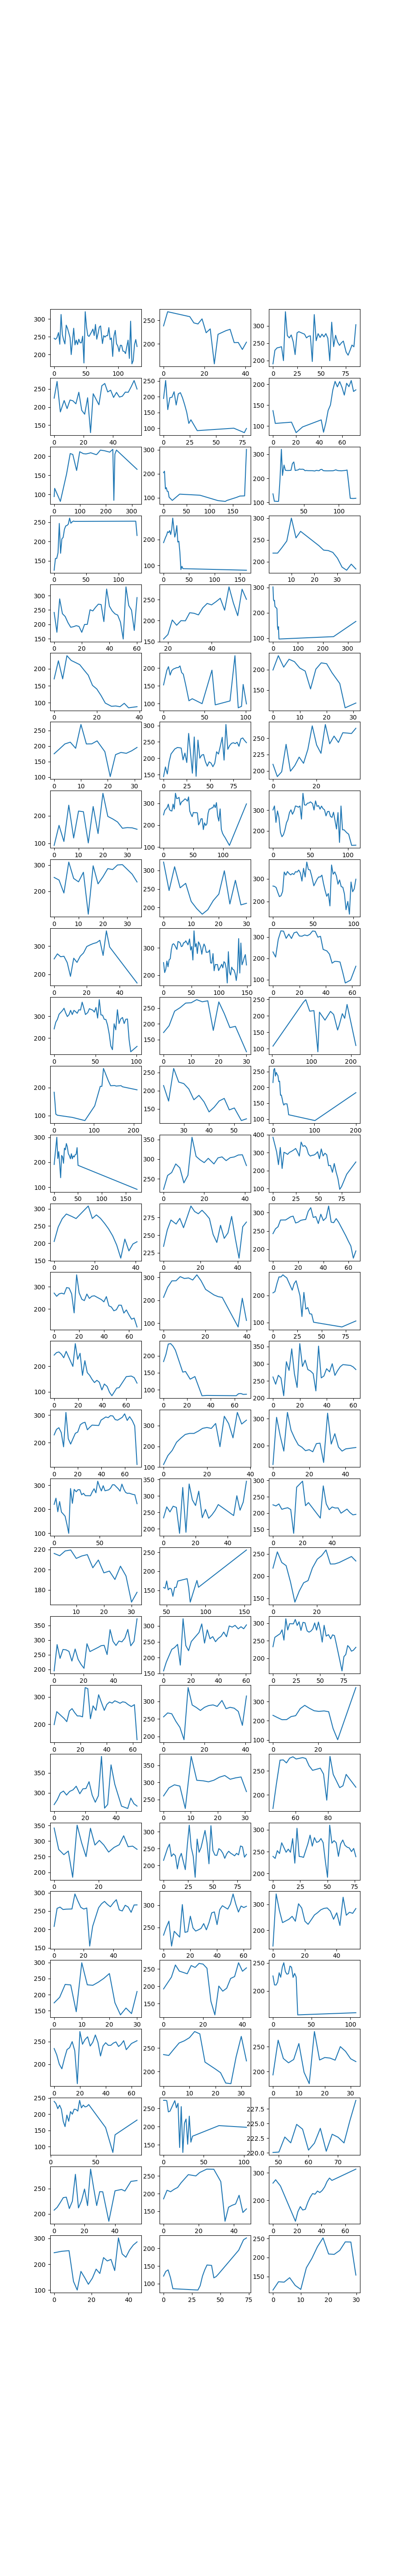

In [96]:
ncols = 3
fig,axs = gridplot(len(select['unique_hypha'].unique()),ncols = ncols,subh = 2,subw = 3)

ax_list = list(axs)

for k,hyph in enumerate(select['unique_hypha'].unique()):
    ax = ax_list[k]
    select_hyph = select[select['unique_hypha']==hyph]
    select_hyph = select_hyph.sort_values('time_since_emergence')
    ax.plot(select_hyph['time_since_emergence'],select_hyph['speed'])
    

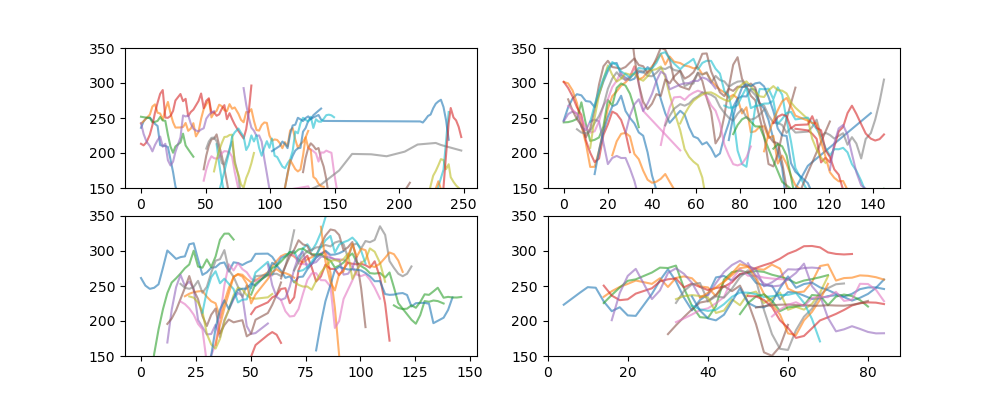

In [143]:
from scipy.signal import savgol_filter
ncols = 2

fig,axs = gridplot(len(plates),ncols = ncols,subh = 2,subw = 5)

ax_list = list(axs)
time_datas_plate = {}
speed_datas_plate = {}

for k,plate in enumerate(plates):
    time_datas = []
    speed_datas = []
    ax = ax_list[k]
    select_plate = select[select['unique_id']==int(plate)]
    for hyph in select_plate['unique_hypha'].unique():
        select_hyph = select[select['unique_hypha']==hyph]
        select_hyph = select_hyph[select_hyph['timestep']<=timestep[int(plate.split('_')[0])]]

        select_hyph = select_hyph.sort_values('time_since_emergence')
        time_data = select_hyph['time_since_begin_exp']
        speed_data = select_hyph['speed']
        time_datas.append(time_data.values)
        speed_datas.append(speed_data.values)
        # Apply Savitzky-Golay smoothing to the speed data
        if len(speed_data) >=9:
            smoothed_speed = savgol_filter(speed_data, window_length=7, polyorder=2)

            ax.plot(time_data, smoothed_speed,alpha = 0.6)
    ax.set_ylim(150,350)
    time_datas_plate[plate] = time_datas
    speed_datas_plate[plate] = speed_datas
    
    # break
    

In [152]:
def generate_all_pairs(input_list):
    all_pairs = []
    for i in range(len(input_list)):
        for j in range(i + 1, len(input_list)):
            pair = (input_list[i], input_list[j])
            all_pairs.append(pair)
    return all_pairs

In [153]:
pair_time_datas =generate_all_pairs(time_datas)
pair_speed_datas =generate_all_pairs(speed_datas)

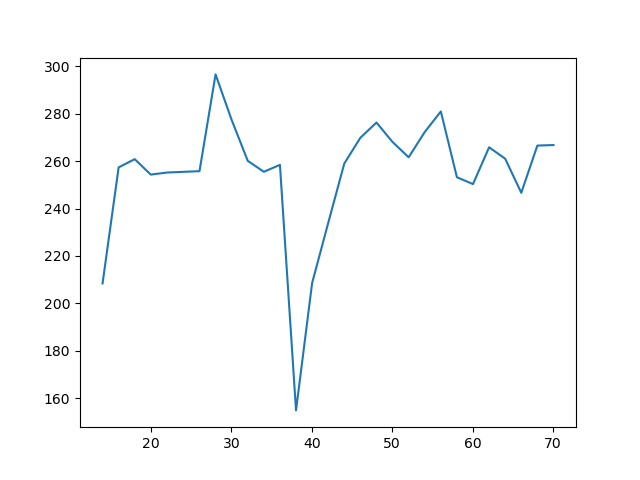

In [189]:
i = 61
xs = pair_time_datas[i]
ys = pair_speed_datas[i]
fig,ax = plt.subplots()
ax.plot(xs[0],ys[0])
ax.plot(xs[1],ys[1])

In [ ]:
def get_cross_corel():

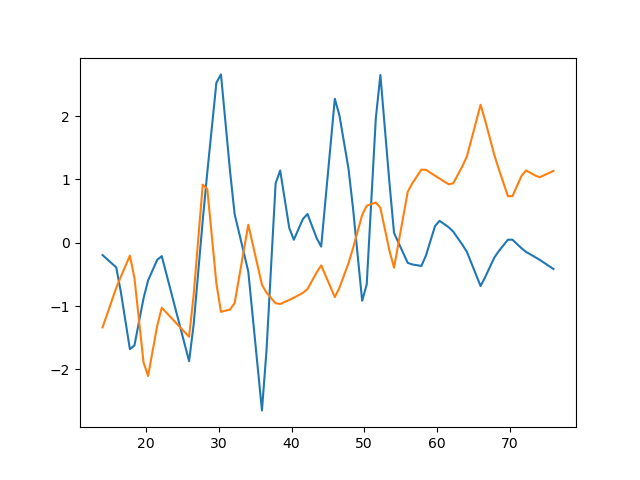

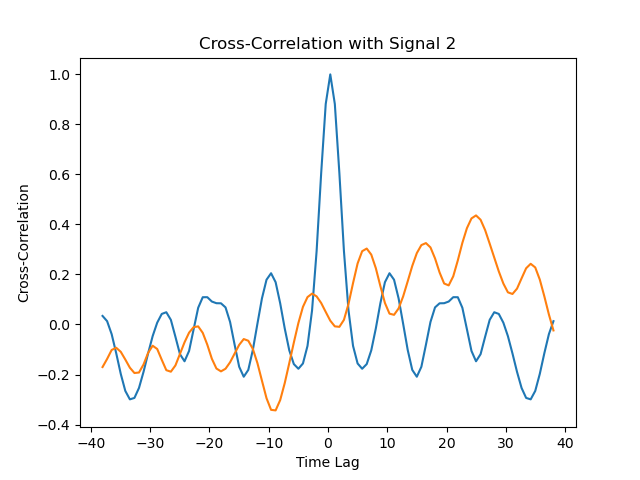

In [187]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

# Determine the overall minimum and maximum timepoints
min_time = max(min(time_points) for time_points in xs)
max_time = min(max(time_points) for time_points in xs)

# Interpolate or resample signals within the common time range
common_time_grid = np.linspace(min_time, max_time, num=100)  # Adjust num as needed
resampled_speed_data = []
fig, ax = plt.subplots()

for i in range(len(xs)):
    resampled_speed = np.interp(common_time_grid, xs[i], ys[i])
    resampled_speed_data.append((resampled_speed-np.mean(resampled_speed))/np.std(resampled_speed))
    ax.plot(common_time_grid,(resampled_speed-np.mean(resampled_speed))/np.std(resampled_speed))
# Compute cross-correlation between the resampled signals
cross_correlations = []
for i in range(len(resampled_speed_data)):
    correlation = correlate(resampled_speed_data[i], resampled_speed_data[0], mode='same')
    cross_correlations.append(correlation)

# Plot cross-correlations
fig, ax = plt.subplots()

for i, correlation in enumerate(cross_correlations):
    time_lags = np.linspace(-max_time/2, max_time/2, len(correlation))
    ax.plot(time_lags, correlation/len(correlation))
    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Cross-Correlation')
    ax.set_title(f'Cross-Correlation with Signal {i + 1}')



In [183]:
np.mean(resampled_speed)

267.6512985254371

In [160]:
min_time

13.983333333333333

In [161]:
max_time

84.03333333333333

In [147]:
time_datas[i]

array([], dtype=float64)